<a href="https://colab.research.google.com/github/Ssurf777/pytorch_tensorflow_MLP_compare/blob/main/PyTorch_SHAP_%3EFinetuning_MLP_regression240520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cali_housing = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/california_housing.csv")
#print(cali_housing)
#cali_housing = fetch_california_housing(as_frame=True)
#x=cali_housing.data
#y=cali_housing.target

#df=cali_housing.frame
df = cali_housing

###外れ値処理(多変量連関図で確認しながら標準偏差で外れ値を処理)
ar_std=df['AveRooms'].std()
ab_std=df['AveBedrms'].std()
pop_std=df['Population'].std()
ao_std=df['AveOccup'].std()

ar_mean=df['AveRooms'].mean()
ab_mean=df['AveBedrms'].mean()
pop_mean=df['Population'].mean()
ao_mean=df['AveOccup'].mean()

limit_low=ar_mean - 1*ab_std
limit_high=ar_mean + 1*ab_std

limit_low1=ab_mean - 1*ab_std
limit_high1=ab_mean + 1*ab_std

limit_low2=pop_mean - 1*pop_std
limit_high2=pop_mean + 1*pop_std

limit_low3=ao_mean - 0.5*ao_std
limit_high3=ao_mean + 0.5*ao_std

newdf=df.query('@limit_low < AveRooms < @limit_high')
newdf1=newdf.query('@limit_low1 < AveBedrms < @limit_high1')
newdf2=newdf1.query('@limit_low2 < Population < @limit_high2')
newdf3=newdf2.query('@limit_low3 < AveOccup < @limit_high3')

#正規化(Max-Min法)
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

df_minmax_norm = minmax_norm(newdf3)
#入力因子をxに代入
x=df_minmax_norm.iloc[:,:8]
#出力因子をyに代入
y=df_minmax_norm.iloc[:,8:9]

# 全体データから未知データを生成
x_know,x_unknown,y_know,y_unknown=train_test_split(x,y,test_size=0.2)
# 既知データから訓練データとテストデータに分割
x_t,x_test,y_t,y_test=train_test_split(x_know,y_know,test_size=0.2)
x_train,x_transfer,y_train,y_transfer=train_test_split(x_t,y_t,test_size=0.2)

print(f"unknown:{x_unknown.shape} test:{x_test.shape} train:{x_train.shape} x_transfer:{x_transfer.shape}")
print(f"unknown:{y_unknown.shape} test:{y_test.shape} train:{y_train.shape} x_transfer:{y_transfer.shape}")
x_transfer2=x_transfer
y_transfer2=y_transfer

unknown:(1107, 8) test:(886, 8) train:(2832, 8) x_transfer:(708, 8)
unknown:(1107, 1) test:(886, 1) train:(2832, 1) x_transfer:(708, 1)


Training - Epoch [10/100], Loss: 0.0564
Validation - Epoch [10/100], Loss: 0.0427
Training - Epoch [20/100], Loss: 0.0228
Validation - Epoch [20/100], Loss: 0.0420
Training - Epoch [30/100], Loss: 0.0303
Validation - Epoch [30/100], Loss: 0.0366
Training - Epoch [40/100], Loss: 0.0051
Validation - Epoch [40/100], Loss: 0.0177
Training - Epoch [50/100], Loss: 0.0005
Validation - Epoch [50/100], Loss: 0.0153
Training - Epoch [60/100], Loss: 0.0182
Validation - Epoch [60/100], Loss: 0.0150
Training - Epoch [70/100], Loss: 0.0013
Validation - Epoch [70/100], Loss: 0.0144
Training - Epoch [80/100], Loss: 0.0045
Validation - Epoch [80/100], Loss: 0.0144
Training - Epoch [90/100], Loss: 0.0027
Validation - Epoch [90/100], Loss: 0.0144
Training - Epoch [100/100], Loss: 0.0028
Validation - Epoch [100/100], Loss: 0.0136


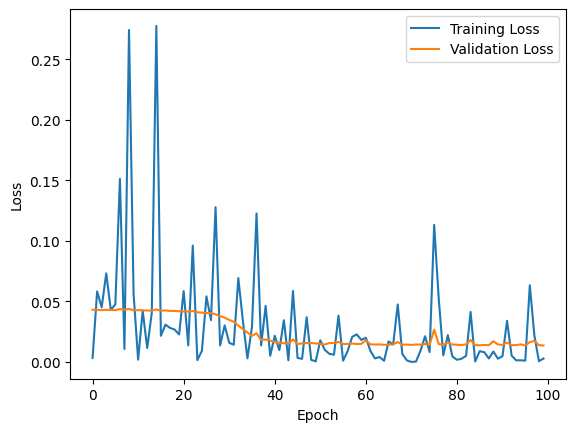

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ランダムシードの設定
fix_seed = 2024
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)


# データをPyTorchのTensorに変換
train_x = torch.FloatTensor(x_train.values)
train_y = torch.FloatTensor(y_train.values)

val_x = torch.FloatTensor(x_test.values)
val_y = torch.FloatTensor(y_test.values)

# GPUが利用可能ならGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データセットとデータローダーの作成
dataset = TensorDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
valdataset = TensorDataset(val_x, val_y)
valdataloader = DataLoader(valdataset, batch_size=10, shuffle=True)





# モデルの定義
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        output = self.regression(x)
        return output

# モデル、損失関数、オプティマイザの初期化
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# トレーニングループ
num_epochs = 100
train_losses = []  # トレーニングの損失を保存するリスト
val_losses = []    # 検証の損失を保存するリスト

for epoch in range(num_epochs):
    model.train()  # モデルをトレーニングモードに切り替え
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # 10エポックごとに損失を表示
    if (epoch + 1) % 10 == 0:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 検証ループ
    model.eval()  # モデルを評価モードに切り替え
    with torch.no_grad():
        val_loss = 0
        for val_batch_x, val_batch_y in valdataloader:
            val_batch_x, val_batch_y = val_batch_x.to(device), val_batch_y.to(device)
            val_output = model(val_batch_x)
            val_loss += criterion(val_output, val_batch_y).item()
        val_loss /= len(valdataloader)
        val_losses.append(val_loss)

        # 10エポックごとに検証の損失を表示
        if (epoch + 1) % 10 == 0:
            print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}')

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### TIPS
Loss関数にMAEを使用するとき
~~~python
criterion = nn.L1Loss() #MAE
~~~

Loss関数にRMSEを使用するとき
~~~python
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

criterion = RMSELoss()
~~~

最適化アルゴリズムにAdamを使用するとき

~~~python
optimizer = optim.Adam(model.parameters(), lr=0.001)
~~~


# 推論

RMSE: 0.11381486058235168


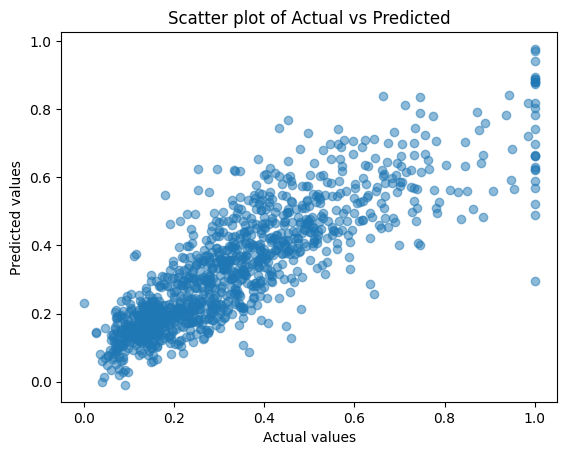

In [28]:
x_un = torch.FloatTensor(x_unknown.values)
y_un = torch.FloatTensor(y_unknown.values)

# モデルを評価モードに切り替え
model.eval()

# 予測
x_un = x_un.to(device)
predicted_output = model(x_un)
pre_result = predicted_output.cpu().detach().numpy()

# RMSEの計算
rmse = np.sqrt(mean_squared_error(y_un, pre_result))
print(f'RMSE: {rmse}')

# 散布図のプロット
plt.scatter(y_un, pre_result, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [29]:
# Torch Script形式で保存
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pth')

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth',map_location="cpu")

In [30]:
# モデルの全パラメータを取得
parameters = list(model_from_scripted.parameters())

# パラメータを表示
for i, param in enumerate(parameters):
    print(f'Parameter {i}:')
    print(param)

Parameter 0:
tensor([[ 0.0447,  0.2428,  0.3311,  ..., -0.1226, -0.2114,  0.0670],
        [-0.0144,  0.1851, -0.2392,  ...,  0.1424,  0.3083, -0.0626],
        [-0.1695,  0.2831,  0.1922,  ...,  0.3169,  0.1550,  0.1710],
        ...,
        [-0.1544, -0.2043, -0.2777,  ..., -0.1060, -0.2667,  0.1997],
        [-0.1641,  0.1040, -0.1985,  ..., -0.0004, -0.1119, -0.0666],
        [-0.3076,  0.0270, -0.1612,  ..., -0.3477,  0.1535,  0.0689]],
       requires_grad=True)
Parameter 1:
tensor([ 2.5102e-01, -1.4269e-02,  2.1335e-02, -5.8187e-02,  6.1751e-02,
        -1.6957e-01, -5.3371e-03,  5.5234e-02, -2.5125e-01,  2.6059e-01,
        -7.3163e-02, -7.1991e-02, -2.3712e-01,  5.1228e-02,  1.9507e-01,
         2.0750e-01,  1.4472e-01, -2.9076e-01, -1.9389e-01,  3.3205e-01,
         3.5799e-01, -2.4348e-01,  2.5727e-01,  3.1240e-01, -2.0337e-01,
        -2.9373e-02, -4.9601e-02,  2.3548e-01, -8.4078e-02, -3.0089e-02,
        -3.3902e-01,  1.8563e-01,  3.2542e-01, -2.3662e-01, -2.2589e-01,
  

In [31]:
# モデルの状態辞書を取得
state_dict = model_from_scripted.state_dict()

# パラメータを表示
for name, param in state_dict.items():
    print(f'Parameter {name}:')
    print(param)

Parameter regression.0.weight:
tensor([[ 0.0447,  0.2428,  0.3311,  ..., -0.1226, -0.2114,  0.0670],
        [-0.0144,  0.1851, -0.2392,  ...,  0.1424,  0.3083, -0.0626],
        [-0.1695,  0.2831,  0.1922,  ...,  0.3169,  0.1550,  0.1710],
        ...,
        [-0.1544, -0.2043, -0.2777,  ..., -0.1060, -0.2667,  0.1997],
        [-0.1641,  0.1040, -0.1985,  ..., -0.0004, -0.1119, -0.0666],
        [-0.3076,  0.0270, -0.1612,  ..., -0.3477,  0.1535,  0.0689]])
Parameter regression.0.bias:
tensor([ 2.5102e-01, -1.4269e-02,  2.1335e-02, -5.8187e-02,  6.1751e-02,
        -1.6957e-01, -5.3371e-03,  5.5234e-02, -2.5125e-01,  2.6059e-01,
        -7.3163e-02, -7.1991e-02, -2.3712e-01,  5.1228e-02,  1.9507e-01,
         2.0750e-01,  1.4472e-01, -2.9076e-01, -1.9389e-01,  3.3205e-01,
         3.5799e-01, -2.4348e-01,  2.5727e-01,  3.1240e-01, -2.0337e-01,
        -2.9373e-02, -4.9601e-02,  2.3548e-01, -8.4078e-02, -3.0089e-02,
        -3.3902e-01,  1.8563e-01,  3.2542e-01, -2.3662e-01, -2.2589e

#DNN 各層の重みの絶対値0.05以下以上で->凍結判断する

In [32]:
import torch

# 各層の重みとバイアスの絶対値を取得
for name, param in model_from_scripted.named_parameters():
    if 'weight' in name:
        # 重みの絶対値を取得
        abs_weights = torch.abs(param)
        # 重みが0.05以下の場合は0に設定
        param.data[abs_weights <= 0.05] = 0
        # 重みが0.05以上の場合は凍結
        param.bool = torch.tensor(abs_weights > 0.05, dtype=torch.bool)
    elif 'bias' in name:
        # バイアスを固定しない
        param.bool = False

# Fine-tuningのためにオプティマイザと損失関数を定義し、学習を行う


<ipython-input-32-888737bc7468>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.bool = torch.tensor(abs_weights > 0.05, dtype=torch.bool)


In [33]:
# 変更されたパラメータを確認
for name, param in model_from_scripted.named_parameters():
    print(f'Parameter: {name}')
    print(param)


Parameter: regression.0.weight
tensor([[ 0.0000,  0.2428,  0.3311,  ..., -0.1226, -0.2114,  0.0670],
        [ 0.0000,  0.1851, -0.2392,  ...,  0.1424,  0.3083, -0.0626],
        [-0.1695,  0.2831,  0.1922,  ...,  0.3169,  0.1550,  0.1710],
        ...,
        [-0.1544, -0.2043, -0.2777,  ..., -0.1060, -0.2667,  0.1997],
        [-0.1641,  0.1040, -0.1985,  ...,  0.0000, -0.1119, -0.0666],
        [-0.3076,  0.0000, -0.1612,  ..., -0.3477,  0.1535,  0.0689]],
       requires_grad=True)
Parameter: regression.0.bias
tensor([ 2.5102e-01, -1.4269e-02,  2.1335e-02, -5.8187e-02,  6.1751e-02,
        -1.6957e-01, -5.3371e-03,  5.5234e-02, -2.5125e-01,  2.6059e-01,
        -7.3163e-02, -7.1991e-02, -2.3712e-01,  5.1228e-02,  1.9507e-01,
         2.0750e-01,  1.4472e-01, -2.9076e-01, -1.9389e-01,  3.3205e-01,
         3.5799e-01, -2.4348e-01,  2.5727e-01,  3.1240e-01, -2.0337e-01,
        -2.9373e-02, -4.9601e-02,  2.3548e-01, -8.4078e-02, -3.0089e-02,
        -3.3902e-01,  1.8563e-01,  3.2542

# DNN 各層の重みの絶対値平均を算出->凍結判断する

In [35]:
import torch

# 各層の重みとバイアスの絶対値の平均値を計算
for name, param in model_from_scripted.named_parameters():
    if 'weight' in name:
        # 重みの絶対値の平均値を計算
        mean_abs_weight = torch.mean(torch.abs(param))
        # 重みが平均値以下の場合は0に設定
        param.data[torch.abs(param) <= mean_abs_weight] = 0
        # 重みが平均値以上の場合は凍結
        param.bool = torch.abs(param) > mean_abs_weight
    elif 'bias' in name:
        # バイアスを固定しない
        param.bool= False

# Fine-tuningのためにオプティマイザと損失関数を定義し、学習を行う



In [36]:
# 変更されたパラメータを確認
for name, param in model_from_scripted.named_parameters():
    print(f'Parameter: {name}')
    print(param)

Parameter: regression.0.weight
tensor([[ 0.0000,  0.2428,  0.3311,  ...,  0.0000, -0.2114,  0.0000],
        [ 0.0000,  0.1851, -0.2392,  ...,  0.0000,  0.3083,  0.0000],
        [ 0.0000,  0.2831,  0.1922,  ...,  0.3169,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.2043, -0.2777,  ...,  0.0000, -0.2667,  0.1997],
        [ 0.0000,  0.0000, -0.1985,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3076,  0.0000,  0.0000,  ..., -0.3477,  0.0000,  0.0000]],
       requires_grad=True)
Parameter: regression.0.bias
tensor([ 2.5102e-01, -1.4269e-02,  2.1335e-02, -5.8187e-02,  6.1751e-02,
        -1.6957e-01, -5.3371e-03,  5.5234e-02, -2.5125e-01,  2.6059e-01,
        -7.3163e-02, -7.1991e-02, -2.3712e-01,  5.1228e-02,  1.9507e-01,
         2.0750e-01,  1.4472e-01, -2.9076e-01, -1.9389e-01,  3.3205e-01,
         3.5799e-01, -2.4348e-01,  2.5727e-01,  3.1240e-01, -2.0337e-01,
        -2.9373e-02, -4.9601e-02,  2.3548e-01, -8.4078e-02, -3.0089e-02,
        -3.3902e-01,  1.8563e-01,  3.2542

In [ ]:
x_transfer.iloc[:500].values
tendata = torch.from_numpy(x_transfer.iloc[:100].values)

In [ ]:
import shap
import torch
import numpy as np

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth', map_location="cpu")

#npdata = np.random.randn(100, 8).astype(np.float32)
#tendata = torch.from_numpy(npdata)


# SHAPのExplainerを作成
def model_forward(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    return model_from_scripted.forward(x_tensor).detach().numpy()

explainer = shap.KernelExplainer(model_forward, tendata.numpy())

# SHAP値の計算
shap_values = explainer.shap_values(tendata.numpy())

# SHAP値のプロット
shap.summary_plot(shap_values, tendata.numpy())


In [ ]:
shap.summary_plot(shap_values, X)



### TIPS
モデルの読み込み
~~~python
# Torch Script形式で保存
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pth')

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth',map_location="cpu")
~~~

In [ ]:
# 新規データのTensorに変換
x_transfer = torch.FloatTensor(x_transfer.values)
y_transfer = torch.FloatTensor(y_transfer.values)

# Fine-Tuning

In [ ]:
print(model_from_scripted)

In [ ]:
# 重みを貼り付ける新モデルの定義
class reMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 16), #　ここを変える
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        output = self.regression(x)
        return output

In [ ]:
remodel = reMLP().to(device)

隠れ層の1層目から3層目の重みを転移し、それらの層をフリーズする

In [ ]:
def transfer_weights(premodel,newmodel,start_layer,end_layer):
  premodel_state_dict = premodel.state_dict()
  newmodel_state_dict = newmodel.state_dict()
  #
  for i in range(start_layer,end_layer+1):
    newmodel_state_dict[f'regression.{i*2}.weight'] = premodel_state_dict[f'regression.{i*2}.weight']
    newmodel_state_dict[f'regression.{i*2}.bias'] = premodel_state_dict[f'regression.{i*2}.bias']
  #
  newmodel.load_state_dict(newmodel_state_dict)

# Transfer weights from layer 0 to 2 (layer 1 to 3)
transfer_weights(model_from_scripted, remodel,start_layer = 0, end_layer = 2 )

In [ ]:
def freeze_layer(model,start_layer,end_layer):
  for i in range(start_layer, end_layer+1):
    for param in model.regression[i*2].parameters():
      param.requires_grad = False
#
freeze_layer(remodel,start_layer = 0, end_layer = 2)

In [ ]:
trans_dataset = TensorDataset(x_transfer, y_transfer)
trans_dataloader = DataLoader(trans_dataset, batch_size=10, shuffle=True)
#valdataset = TensorDataset(val_x, val_y)
#valdataloader = DataLoader(valdataset, batch_size=10, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.SGD(remodel.parameters(), lr=0.01)

# トレーニングループ
num_epochs = 200
train_losses = []  # トレーニングの損失を保存するリスト
val_losses = []    # 検証の損失を保存するリスト

for epoch in range(num_epochs):
    remodel.train()  # モデルをトレーニングモードに切り替え
    for batch_x, batch_y in trans_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = remodel(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # 10エポックごとに損失を表示
    if (epoch + 1) % 10 == 0:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 検証ループ
    remodel.eval()  # モデルを評価モードに切り替え
    with torch.no_grad():
        val_loss = 0
        for val_batch_x, val_batch_y in valdataloader:
            val_batch_x, val_batch_y = val_batch_x.to(device), val_batch_y.to(device)
            val_output = remodel(val_batch_x)
            val_loss += criterion(val_output, val_batch_y).item()
        val_loss /= len(valdataloader)
        val_losses.append(val_loss)

        # 10エポックごとに検証の損失を表示
        if (epoch + 1) % 10 == 0:
            print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}')

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# モデルを評価モードに切り替え
remodel.eval()

# 予測
x_un = x_un.to(device)
predicted_output = remodel(x_un)
pre_result = predicted_output.cpu().detach().numpy()

# RMSEの計算
rmse = np.sqrt(mean_squared_error(y_un, pre_result))
print(f'RMSE: {rmse}')

# 散布図のプロット
plt.scatter(y_un, pre_result, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

SHAP

In [ ]:
!pip install shap

In [ ]:
import torch
import shap
import numpy as np

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth',map_location="cpu")


# ダミーデータの作成
train_x = np.random.randn(10, 8)

# SHAPのExplainerを定義（KernelExplainerを使用）
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')  # 入力をCPUに配置
    with torch.no_grad():
        predictions = model_from_scripted(inputs)
    return predictions.numpy()  # NumPy配列を返す

# SHAP用にNumPy配列を使用
explainer = shap.KernelExplainer(model_predict, shap.kmeans(train_x, 10))
shap_values = explainer.shap_values(train_x)

# SHAP値を表示
#print(shap_values)


# SHAP値を集計して重みごとに重要性を算出
weight_importance = np.mean(np.abs(shap_values), axis=0)

def freeze_top_weights_by_shap(model, weight_importance, freeze_ratio=0.3):
    all_params = [(name, param) for name, param in model.named_parameters() if 'weight' in name]

    # SHAP値の重要度に基づいてパラメータをソート
    sorted_params = sorted(all_params, key=lambda x: weight_importance[x[0]], reverse=True)

    # 凍結するパラメータの数を計算
    num_params_to_freeze = int(len(sorted_params) * freeze_ratio)

    # 凍結するパラメータを選択し、requires_gradをFalseに設定
    for name, param in sorted_params[:num_params_to_freeze]:
        param.requires_grad = False
        print(f"Freezing parameter: {name}")

    # 凍結されていないパラメータを確認
    for name, param in sorted_params[num_params_to_freeze:]:
        param.requires_grad = True
        print(f"Training parameter: {name}")

# 凍結関数を適用
freeze_top_weights_by_shap(model_from_scripted, weight_importance, freeze_ratio=0.3)

'''
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ダミーデータセットの作成
y_train = torch.randn(100, 1)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# ロス関数とオプティマイザの設定
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
'''

In [ ]:
import torch
import shap
import numpy as np

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth', map_location="cpu")

# ダミーデータの作成　(データ数、入力因子)
train_x = np.random.randn(100, 8)

# SHAPのExplainerを定義（KernelExplainerを使用）
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')  # 入力をCPUに配置
    with torch.no_grad():
        predictions = model_from_scripted(inputs)
    return predictions.numpy()  # NumPy配列を返す

# SHAP用にNumPy配列を使用 (train_x,データ数)
explainer = shap.KernelExplainer(model_predict, shap.kmeans(train_x, 100))
shap_values = explainer.shap_values(train_x)

# SHAP値を表示
# print(shap_values)

# SHAP値を集計して重みごとに重要性を算出
weight_importance = np.mean(np.abs(shap_values), axis=0)

# weight_importance を辞書形式でパラメータ名と対応付ける
param_names = [name for name, param in model_from_scripted.named_parameters() if 'weight' in name]
weight_importance_dict = {name: weight_importance[i] for i, name in enumerate(param_names)}

def freeze_top_weights_by_shap(model, weight_importance_dict, freeze_ratio=0.3):
    all_params = [(name, param) for name, param in model.named_parameters() if 'weight' in name]

    # SHAP値の重要度に基づいてパラメータをソート
    sorted_params = sorted(all_params, key=lambda x: weight_importance_dict.get(x[0], 0), reverse=True)

    # 凍結するパラメータの数を計算
    num_params_to_freeze = int(len(sorted_params) * freeze_ratio)

    # 凍結するパラメータを選択し、requires_gradをFalseに設定
    for name, param in sorted_params[:num_params_to_freeze]:
        param.requires_grad = False
        print(f"Freezing parameter: {name}")

    # 凍結されていないパラメータを確認
    for name, param in sorted_params[num_params_to_freeze:]:
        param.requires_grad = True
        print(f"Training parameter: {name}")

# 凍結関数を適用
freeze_top_weights_by_shap(model_from_scripted, weight_importance_dict, freeze_ratio=0.3)


In [ ]:
import torch
import shap
import numpy as np

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth', map_location="cpu")

# ダミーデータの作成
train_x = np.random.randn(10, 8)

# SHAPのExplainerを定義（KernelExplainerを使用）
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')  # 入力をCPUに配置
    with torch.no_grad():
        predictions = model_from_scripted(inputs)
    return predictions.numpy()  # NumPy配列を返す

# SHAP用にNumPy配列を使用
explainer = shap.KernelExplainer(model_predict, shap.kmeans(train_x, 10))
shap_values = explainer.shap_values(train_x)

# SHAP値を表示
# print(shap_values)

# SHAP値を集計して重みごとに重要性を算出
weight_importance = np.mean(np.abs(shap_values), axis=0)

# weight_importance を辞書形式でパラメータ名と対応付ける
param_names = [name for name, param in model_from_scripted.named_parameters() if 'weight' in name]
weight_importance_dict = {name: weight_importance[i] for i, name in enumerate(param_names)}

def freeze_top_weights_by_shap(model, weight_importance_dict, freeze_ratio=0.3):
    for name, param in model.named_parameters():
        if 'weight' in name:
            # パラメータの重みを取り出し、重要度順にソート
            param_importance = weight_importance_dict.get(name, np.zeros(param.shape))
            sorted_indices = np.argsort(-param_importance)  # 降順にソート
            num_weights_to_freeze = int(param.numel() * freeze_ratio)  # 凍結する重みの数

            # 重みをテンソルとしてコピーし、重要度の高い部分を凍結
            for idx in sorted_indices[:num_weights_to_freeze]:
                param.data.view(-1)[idx] = param.data.view(-1)[idx]
                param.requires_grad = False
                print(f"Freezing weight index: {idx} in parameter: {name}")

    # 凍結されていないパラメータを確認
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Training parameter: {name}")

# 凍結関数を適用
freeze_top_weights_by_shap(model_from_scripted, weight_importance_dict, freeze_ratio=0.3)


In [ ]:
import torch
import shap
import numpy as np

# Torch Script形式で読み込み
model_from_scripted = torch.jit.load('model_scripted.pth', map_location="cpu")

# ダミーデータの作成
train_x = np.random.randn(10, 8)

# SHAPのExplainerを定義（KernelExplainerを使用）
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')  # 入力をCPUに配置
    with torch.no_grad():
        predictions = model_from_scripted(inputs)
    return predictions.numpy()  # NumPy配列を返す

# SHAP用にNumPy配列を使用
explainer = shap.KernelExplainer(model_predict, shap.kmeans(train_x, 10))
shap_values = explainer.shap_values(train_x)

# SHAP値を集計してニューロンごとに重要性を算出
layer_importance = np.mean(np.abs(shap_values), axis=0)

def freeze_specific_neuron(model, layer_name, neuron_index):
    # 特定の層のパラメータを取得
    for name, param in model.named_parameters():
        if name == layer_name:
            # パラメータの形状を取得
            weight_shape = param.shape
            if len(weight_shape) == 2:  # 全結合層 (Linear) を仮定
                # 特定のニューロンの重みを凍結
                with torch.no_grad():
                    param[:, neuron_index] = param[:, neuron_index]
                param.requires_grad = False
                print(f"Freezing neuron index: {neuron_index} in layer: {layer_name}")

# 凍結関数を適用
# 例: 2層目（仮に 'layer2.weight' とする）の3番目のニューロンを凍結
freeze_specific_neuron(model_from_scripted, 'regression.1.weight', 2)


# Tensorflowで記述した場合

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

# ランダムシードの設定
fix_seed = 2024
np.random.seed(fix_seed)
# TensorFlowのランダムシードの固定
tf.random.set_seed(fix_seed)

# モデルの定義
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.regression = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(1)
        ])

    def call(self, x):
        return self.regression(x)

# GPU上でモデルを構築
with tf.device('/GPU:0'):
    model_tf = MLP()

# モデル、損失関数、オプティマイザの初期化
criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.SGD(learning_rate=0.01)

# データセットの作成
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_x)).batch(10)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(10)

# モデルのコンパイル
model_tf.compile(optimizer=optimizer, loss=criterion)

# トレーニング
hist = model_tf.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    verbose=1)

# トレーニングと検証の損失履歴を取得
train_losses = hist.history['loss']
val_losses = hist.history['val_loss']

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Tensorflowでの推論

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 未知データをテンソルに変換
x_un_tf = tf.constant(x_unknown.values, dtype=tf.float32)
y_un_tf = tf.constant(y_unknown.values, dtype=tf.float32)


# TensorFlowモデルの予測
predicted_output_tf = model_tf(x_un_tf, training=False)
pre_result_tf = predicted_output_tf.numpy()

# RMSEの計算
rmse_tf = np.sqrt(mean_squared_error(y_un_tf, pre_result_tf))
print(f'RMSE: {rmse_tf}')

# 散布図のプロット
plt.scatter(y_un_tf, pre_result_tf, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# モデルを保存
model_tf.save('my_tf_mlp_model')

In [ ]:
x_transfer2 = tf.constant(x_transfer2.values, dtype=tf.float32)
y_transfer2 = tf.constant(y_transfer2.values, dtype=tf.float32)
transfer_train_dataset = tf.data.Dataset.from_tensor_slices((x_transfer2, y_transfer2))
transfer_train_dataset = transfer_train_dataset.shuffle(buffer_size=len(x_transfer2)).batch(10)

In [ ]:
# モデルの定義
class reMLP(tf.keras.Model):
    def __init__(self):
        super(reMLP, self).__init__()
        self.regression = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(16, activation='relu'),  # 追加
            layers.Dense(1)
        ])

# モデルのインスタンスを作成
re_mlp_model = reMLP()

# 事前学習済みモデルのロードなどがあればここで行う
re_mlp_model = tf.keras.models.load_model('my_tf_mlp_model')

# モデル、損失関数、オプティマイザの初期化
criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.SGD(learning_rate=0.01)
# モデルのコンパイル
re_mlp_model.compile(optimizer=optimizer, loss=criterion)

# Fine-tuningしたい層のインデックスを取得
fine_tune_from = -3  # 最後から3つの層をFine-tuning

# ファインチューニングのために指定した層より前は凍結
for layer in re_mlp_model.regression.layers[:fine_tune_from]:
    layer.trainable = False

# モデルのコンパイル
re_mlp_model.compile(optimizer=optimizer, loss=criterion)

# トレーニング
hist2 = re_mlp_model.fit(transfer_train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    verbose=1)

# トレーニングと検証の損失履歴を取得
train_losses2 = hist2.history['loss']
val_losses2 = hist2.history['val_loss']

# TrainとValのLossをプロット
plt.plot(train_losses2, label='Training Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 未知データをテンソルに変換
x_un_tf = tf.constant(x_unknown.values, dtype=tf.float32)
y_un_tf = tf.constant(y_unknown.values, dtype=tf.float32)


# TensorFlowモデルの予測
predicted_output_tf = re_mlp_model(x_un_tf, training=False)
pre_result_tf = predicted_output_tf.numpy()

# RMSEの計算
rmse_tf = np.sqrt(mean_squared_error(y_un_tf, pre_result_tf))
print(f'RMSE: {rmse_tf}')

# 散布図のプロット
plt.scatter(y_un_tf, pre_result_tf, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()